# Bootstrap Current Self-Consistency

This tutorial demonstrates how to optimize a quasi-symmetric equilibrium to have a self-consistent bootstrap current profile. 
This is performed by minimizing the difference between the toroidal currents $\langle J \cdot B \rangle$ computed from the MHD equilibrium and from the Redl formula. 
The Redl formula is only valid in the limit of perfect quasi-symmetry, so this procedure will not work for other configurations that are not quasi-symmetric. 

There are two methods that can be used, and both will be shown: 

1. Optimize the current profile for self-consistency
2. Iteratively solve the equilibrium with new current profiles

These methods should be equivalent, although one might be faster than the other depending on the particular problem. 

If you have access to a GPU, uncomment the following two lines: 

In [1]:
# from desc import set_device
# set_device("gpu")

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

from desc.compat import rescale
from desc.equilibrium import EquilibriaFamily
from desc.examples import get
from desc.grid import LinearGrid
from desc.objectives import (
    BootstrapRedlConsistency,
    FixAtomicNumber,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixElectronDensity,
    FixElectronTemperature,
    FixIonTemperature,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.plotting import plot_1d
from desc.profiles import PowerSeriesProfile

DESC version 0.10.2+305.gb1abd2fa,using JAX backend, jax version=0.4.11, jaxlib version=0.4.11, dtype=float64
Using device: CPU, with 10.29 GB available memory


As an example, we will reproduce the QA results from [Landreman et al. (2022)](https://doi.org/10.1063/5.0098166). 

We will start with the "precise QA" example equilibrium, scaled to the ARIES-CS reactor size. 

In [4]:
eq0 = get("precise_QA")
eq0 = rescale(eq0, L=("R0", 10), B=("B0", 5.86))

Calculating the bootstrap current requires knowledge of the temperature and density profiles for each species in the plasma. 
We replace the vacuum pressure profile with the following kinetic profiles corresponding to $\langle\beta\rangle=2.5\%$: 

$n_e = n_i = 2.38\times10^{20} (1 - \rho^{10}) ~\text{m}^{-3}$

$T_e = T_i = 9.45\times10^{3} (1 - \rho^{2}) ~\text{eV}$

The temperature profiles must be given for both ions and electrons, but only the electron density profile is specified. 
The ion density profile is given by the effective atomic number $Z_{eff}$ as $n_i = n_e / Z_{eff}$. 

In [5]:
eq0.pressure = None
eq0.atomic_number = PowerSeriesProfile([1])
eq0.electron_density = PowerSeriesProfile(params=[1, -1], modes=[0, 10]) * 2.38e20
eq0.electron_temperature = PowerSeriesProfile(params=[1, -1], modes=[0, 2]) * 9.45e3
eq0.ion_temperature = PowerSeriesProfile(params=[1, -1], modes=[0, 2]) * 9.45e3
# the default current profile is the vacuum case eq0.current = PowerSeriesProfile([0])

We need to re-solve the equilibrium force balance with the new profiles. 

In [6]:
eq0, _ = eq0.solve(objective="force", optimizer="lsq-exact", verbose=3)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.04 sec
Timer: Objective build = 2.48 sec
Timer: Linear constraint projection build = 5.53 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.96 sec
Timer: Jacobian compilation time = 5.45 sec
Timer: Total compilation time = 7.42 sec
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.506e-02                                    1.077e+01   
       1              4          2.845e-04      1.478e-02      9.222e-02      2.691e+00   
       2              5          1.830e-04      1.014e-04      1.397e-01      1.249e+00   
       3              6          1.089e-04      7.414e-05      1.213e-01      7.621e-01   
       4              7          3.200e-05      7.690e-05      9.716e-02      6.3

Now we have our initial equilibrium, which does not have a self-consistent bootstrap current: 

Text(0.5, 1.0, 'Initial Equilibrium')

/home/dudt/anaconda3/envs/desc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


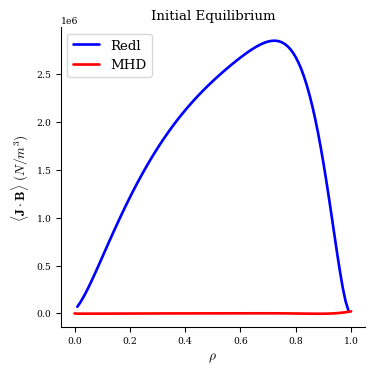

In [7]:
fig, ax = plot_1d(eq0, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq0, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Initial Equilibrium")

We need to create a grid on which to evaluate the boootstrap current self-consistency. 
The bootstrap current is a radial profile, but the grid must have finite poloidal and toroidal resolution to accurately compute flux surface quantities. 
The Redl formula is undefined where the kinetic profiles vanish, so in our example we do not include points at $\rho=0$ or $\rho=1$. 

In [8]:
grid = LinearGrid(
    M=eq0.M_grid,
    N=eq0.N_grid,
    NFP=eq0.NFP,
    sym=eq0.sym,
    rho=np.linspace(1 / eq0.L_grid, 1, eq0.L_grid) - 1 / (2 * eq0.L_grid),
)

Our current profile will be represented as a power series of the form: 

$I = c_0 + c_1 \rho + c_2 \rho^2 + \mathcal{O}(\rho^3)$

Physically, the current should vanish on the magnetic axis so $c_0 = 0$. 
And in order for the MHD equilibrium to be analytic, it should scale as $\mathcal{O}(\rho^2)$ near the magnetic axis so $c_1 = 0$ also. 
However, the Redl bootstrap current formula scales as $\mathcal{O}(\sqrt{\rho})$ near the magnetic axis. 
This is incorrect, because the drift-kinetic equation from the Redl formula does not account for finite orbit width effects that become important near the axis. 

Typically, we use even power series with `sym=True` for all equilibrium profiles to give the desired analycity conditions. 
For bootstrap current optimizations, it is recommended to use the full power series with `sym=False` while also enforcing $c_0 = c_1 = 0$. 
This prevents getting good self-consistency near the magnetic axis, but allows for good agreement throughout the rest of the plasma volume and results in high quality equilibria overall. 


In [ ]:
eq0.current = PowerSeriesProfile(np.zeros((eq0.L + 1,)), sym=False)

### 1. Optimization

In this method, we will optimize the current profile to minimize the self-consistency errors evaluated by the `BootstrapRedlConsistency` objective. 
This objective requires the helicity, which for QA is $(M, N) = (1, 0)$. 

In this example we will only optimize the current profile, so all other profiles and the plasma boundary are constrained to be fixed. 
It is recommended to use a very small value for `gtol` when optimizing the bootstrap current. 

In [9]:
eq1 = eq0.copy()

In [10]:
objective = ObjectiveFunction(
    BootstrapRedlConsistency(eq=eq1, grid=grid, helicity=(1, 0)),
    verbose=0,
)
constraints = (
    FixAtomicNumber(eq=eq1),
    FixBoundaryR(eq=eq1),
    FixBoundaryZ(eq=eq1),
    FixCurrent(eq=eq1, indices=[0, 1]),  # fix c_0=c_1=0 current profile coefficients
    FixElectronDensity(eq=eq1),
    FixElectronTemperature(eq=eq1),
    FixIonTemperature(eq=eq1),
    FixPsi(eq=eq1),
    ForceBalance(eq=eq1),
)
eq1, _ = eq1.optimize(
    objective=objective,
    constraints=constraints,
    optimizer="proximal-lsq-exact",
    gtol=1e-16,  # it is recommended to use a very small gtol
    verbose=3,
)

Building objective: Bootstrap current self-consistency (Redl)
Precomputing transforms
Timer: Precomputing transforms = 1.13 sec
Timer: Objective build = 2.37 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 135 ms
Timer: Objective build = 351 ms
Timer: Proximal projection build = 5.60 sec
Timer: Linear constraint projection build = 2.96 sec
Compiling objective function and derivatives: ['Bootstrap current self-consistency (Redl)']
Timer: Objective compilation time = 2.33 sec
Timer: Jacobian compilation time = 9.37 sec
Timer: Total compilation time = 11.7 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 2.67 sec
Timer: Jacobian compilation time = 6.73 sec
Timer: Total compilation time = 9.41 sec
Number of parameters: 7
Number of objectives: 16
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0        

When plotting the bootstrap current profiles, we see the MHD equilibrium now has very good agreement with the Redl formula. 

Text(0.5, 1.0, 'Method 1: Optimization')

/home/dudt/anaconda3/envs/desc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


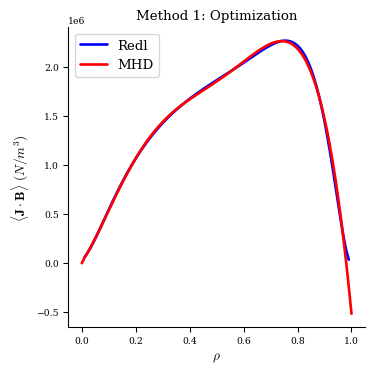

In [19]:
fig, ax = plot_1d(eq1, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq1, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Method 1: Optimization")

### 2. Iterative Solves

In this method, we iteratively solve the equilibrium with updated guesses for the current profile. 
The current profile is computed such that the parallel current is consistent with the Redl formula, according to Equation C3 in [Landreman & Catto (2012)](https://doi.org/10.1063/1.3693187). 
This is the same approach as STELLOPT VBOOT with SFINCS, and it usually converges in only a few iterations. 

In [12]:
eq2 = eq0.copy()
fam2 = EquilibriaFamily(eq2)

In [17]:
niters = 3
for k in range(niters):
    eq2 = eq2.copy()
    # compute new guess for the current profile, consistent with Redl formula
    data = eq2.compute("current Redl", grid)
    rho = np.atleast_2d(grid.compress(data["rho"])).T
    current = grid.compress(data["current Redl"])
    # fit the current profile to a power series, with c_0=c_1=0
    XX = rho**2
    for p in range(3, eq2.L + 1):
        XX = np.hstack((XX, rho**p))
    eq2.c_l = np.pad(np.linalg.lstsq(XX, current, rcond=None)[0], (2, 0))
    # re-solve the equilibrium
    eq2, _ = eq2.solve(objective="force", optimizer="lsq-exact", verbose=3)
    fam2.append(eq2)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 123 ms
Timer: Objective build = 330 ms
Timer: Linear constraint projection build = 2.30 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.58 sec
Timer: Jacobian compilation time = 5.11 sec
Timer: Total compilation time = 6.70 sec
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.847e-06                                    8.794e-02   
       1              2          1.507e-06      3.407e-07      3.380e-03      1.274e-03   
       2              3          1.506e-06      4.310e-10      2.323e-03      5.321e-04   
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 1.506e-06
         Total delta_x: 4.997e-03
         Iterations: 2
         F

We can plot the current profile at each iteration to visualize how it changed: 

/home/dudt/anaconda3/envs/desc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


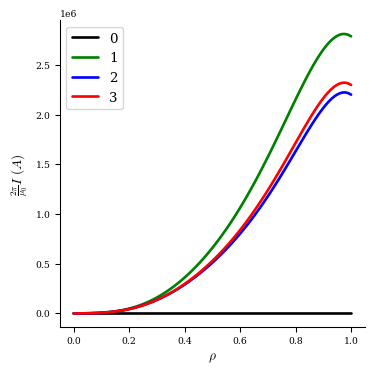

In [14]:
fig, ax = plot_1d(fam2[0], "current", linecolor="k", lw=2, label="0")
fig, ax = plot_1d(fam2[1], "current", linecolor="g", lw=2, label="1", ax=ax)
fig, ax = plot_1d(fam2[2], "current", linecolor="b", lw=2, label="2", ax=ax)
fig, ax = plot_1d(fam2[3], "current", linecolor="r", lw=2, label="3", ax=ax)
ax.legend(loc="best")

With this method the MHD equilibrium also has very good agreement with the Redl formula. 

Text(0.5, 1.0, 'Method 2: Iterative Solves')

/home/dudt/anaconda3/envs/desc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


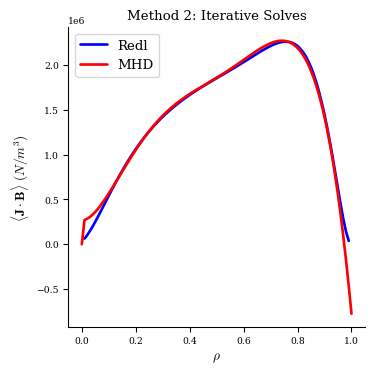

In [15]:
fig, ax = plot_1d(eq2, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq2, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Method 2: Iterative Solves")

Even though both methods give good self-consistency for the bootstrap current, they do result in slightly different coefficients for the current profile: 

In [16]:
print(eq1.c_l)
print(eq2.c_l)

[ 0.00000000e+00  0.00000000e+00  2.67019470e+03  3.97402482e+06
  1.66002514e+07 -6.86550329e+07  1.01228131e+08 -6.28828607e+07
  1.20716658e+07]
[ 0.00000000e+00  0.00000000e+00  3.81520713e+05  1.84045895e+05
  3.12490924e+07 -9.62269043e+07  1.27167562e+08 -7.35176799e+07
  1.30614794e+07]


In [30]:
grid = LinearGrid(
    M=eq0.M_grid,
    N=eq0.N_grid,
    NFP=eq0.NFP,
    sym=eq0.sym,
    rho=np.linspace(0.2, 0.9, 8),
)
data1 = eq1.compute(["<J*B> Redl", "<J*B>"], grid)
data2 = eq2.compute(["<J*B> Redl", "<J*B>"], grid)

In [34]:
np.testing.assert_allclose(
    grid.compress(data1["<J*B>"]), grid.compress(data1["<J*B> Redl"]), rtol=3e-2
)
np.testing.assert_allclose(
    grid.compress(data2["<J*B>"]), grid.compress(data2["<J*B> Redl"]), rtol=2e-2
)
np.testing.assert_allclose(grid.compress(data1["<J*B>"]), grid.compress(data2["<J*B>"]), rtol=4e-2)

: 